<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Simplified/StocksApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**


In [1]:
# #refesh python script
# get_ipython().kernel.do_shutdown(restart=True)

# #Check GPUs
# !nvidia-smi

#load cudf to use GPUs for analysis
#%load_ext cudf.pandas

# import pandas
import pandas as pd
import datetime
import pickle
import numpy as np
from tqdm.notebook import tqdm
import requests
from datetime import datetime, timedelta
import time
import os

#!pip install tqdm==4.66.1



# Ensure the last 6 months of EODHD Data is available

In [ ]:
# Ensure the last 6 months of EODHD Data is available

#API_KEY = 'demo'  # Replace with your API key if not using demo
API_KEY = '68433aff09ea73.10710364'
EXCHANGE = 'NASDAQ'
DAYS_BACK = 180  # Approx. 6 months
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv'
MAX_CALLS_PER_RUN = 200  # Use 1–5 for the free tier
SECONDS_BETWEEN_CALLS = 0  # Add delay to be respectful

# Generate past 6 months of weekdays
today = datetime.utcnow().date()
dates = [today - timedelta(days=i) for i in range(DAYS_BACK)]
dates = sorted([d for d in dates if d.weekday() < 5])  # Keep only weekdays

# Load already-downloaded dates if file exists
downloaded_dates = set()
if os.path.exists(SAVE_PATH):
    df_existing = pd.read_csv(SAVE_PATH)
    downloaded_dates = set(pd.to_datetime(df_existing['date']).dt.date)

# Filter to only dates we haven’t downloaded
pending_dates = [d for d in dates if d not in downloaded_dates]

# Prepare data holder
all_data = []

for i, date in enumerate(pending_dates[:MAX_CALLS_PER_RUN]):
    date_str = date.strftime('%Y-%m-%d')
    url = f'https://eodhd.com/api/eod-bulk-last-day/{EXCHANGE}?api_token={API_KEY}&fmt=json&date={date_str}'
    print(f"[{i+1}] Fetching {date_str}...")

    try:
        response = requests.get(url)
        response.raise_for_status()
        day_data = response.json()

        for entry in day_data:
            all_data.append({
                'date': entry.get('date'),
                'ticker': entry.get('code'),
                'open': entry.get('open'),
                'high': entry.get('high'),
                'low': entry.get('low'),
                'close': entry.get('close'),
                'adjusted_close': entry.get('adjusted_close'),
                'volume': entry.get('volume'),
            })

        # Respect the delay
        if i < MAX_CALLS_PER_RUN - 1:
            time.sleep(SECONDS_BETWEEN_CALLS)

    except Exception as e:
        print(f"⚠️ Error on {date_str}: {e}")

# Append or save the new data
if all_data:
    df_new = pd.DataFrame(all_data)
    if os.path.exists(SAVE_PATH):
        df_existing = pd.read_csv(SAVE_PATH)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(SAVE_PATH, index=False)
    print(f"✅ Data for {len(all_data)} entries added to {SAVE_PATH}")
else:
    print("⚠️ No new data fetched.")

# # Import CSV into code
# nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")

[1] Fetching 2025-06-09...
⚠️ No new data fetched.


# Get list of Tickers with Min Market Cap

In [3]:

# -------------------- CONFIG --------------------
API_KEY = '68433aff09ea73.10710364'  # Replace with your EODHD key
MIN_MARKET_CAP = 10_000_000_000  # Changeable: $1B, $10B, etc.
EXCHANGE = 'NASDAQ'
RESULTS_PER_PAGE = 500  # Max per EODHD API
# ------------------------------------------------

def get_filtered_nasdaq_stocks(api_key, min_cap, exchange="NASDAQ"):
    all_data = []
    offset = 0

    while True:
        url = (
            "https://eodhd.com/api/screener"
            f"?api_token={api_key}"
            f"&filters=["
            f'["exchange","=","{exchange}"],'
            #f'["type","=","Common Stock"],'
            f'["market_capitalization",">=",{min_cap}]'
            f"]"
            f"&sort=market_capitalization.desc"
            f"&limit={RESULTS_PER_PAGE}&offset={offset}&fmt=json"
        )

        response = requests.get(url)
        result = response.json()
        batch = result.get("data", [])

        if not batch:
            break

        all_data.extend(batch)
        offset += RESULTS_PER_PAGE

    return pd.DataFrame(all_data)

# Run filter
min_market_cap_df = get_filtered_nasdaq_stocks(API_KEY, MIN_MARKET_CAP)



# Filter nasdaq for common stocks and min_market_cap

meta_url = f'https://eodhd.com/api/exchange-symbol-list/NASDAQ?api_token={API_KEY}&fmt=json'
meta_df = pd.DataFrame(requests.get(meta_url).json())
common_df = meta_df[meta_df['Type'] == 'Common Stock']



In [9]:
min_market_cap_df.head()

,code,name,last_day_data_date,adjusted_close,refund_1d,refund_1d_p,refund_5d,refund_5d_p,exchange,currency_symbol,market_capitalization,earnings_share,dividend_yield,sector,industry,avgvol_1d,avgvol_200d
0,MSFT,Microsoft Corporation,2025-06-06,470.38,2.7000,0.58,10.0200,2.18,US,$,3496118321152,12.94,0.0071,Technology,Software - Infrastructure,15278600,2.180867e+07
1,NVDA,NVIDIA Corporation,2025-06-06,141.72,1.7300,1.24,6.5900,4.88,US,$,3456210829312,3.10,0.0003,Technology,Semiconductors,153986203,2.652275e+08
2,AAPL,Apple Inc,2025-06-06,203.92,3.2900,1.64,3.0700,1.53,US,$,3045708267520,6.42,0.0051,Technology,Consumer Electronics,46539200,5.298225e+07
3,AMZN,Amazon.com Inc,2025-06-06,213.57,5.6600,2.72,8.5600,4.18,US,$,2267344535552,6.13,NaN,Consumer Cyclical,Internet Retail,39832500,4.138886e+07
4,GOOGL,Alphabet Inc Class A,2025-06-06,173.26,5.2536,3.13,1.7279,1.01,US,$,2114328199168,8.96,0.0048,Communication Services,Internet Content & Information,0,3.117048e+07


# Filter nasdaq data for common and min_market_cap

In [4]:
# prompt: I want to filter the Nasdaq stocks to only include tickers that are part of the common_df and the min_market_cap_df. Same this df as a new variable
# Load your EOD data
from datetime import datetime, timedelta
nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

filtered_nasdaq_df = nasdaq_df[
    nasdaq_df['ticker'].isin(common_df['Code']) &
    nasdaq_df['ticker'].isin(min_market_cap_df['code'])
]

# Function: Correlation Coeficient for entire stock data set

In [6]:
# prompt: I want to modify the function calculate_lagged_correlation to be able to take in the nasdaq_df variable.
# Also, I do not want to put in the end date. The function will automatically select the start_datetime by
# subtracting the range_months from today’s date.

import pandas as pd
from datetime import datetime # Import datetime
from tqdm.notebook import tqdm # Import tqdm

# ## Function: Correlation Coeficient for entire stock data set
def calculate_lagged_correlation(df, lag_days, range_months):
  """
  Calculates the pairwise spearman correlation coefficient between all stocks
  in a DataFrame for a specified period with a given lag.
  The start date is calculated by subtracting range_months from today's date.

  Args:
    df: DataFrame with 'date', 'ticker', and 'adjusted_close' columns.
    lag_days: The number of days to lag the second stock's data.
    range_months: The number of months to include in the analysis period.

  Returns:
    A pandas DataFrame containing the pairwise correlation coefficients.
  """
  # Calculate the end date (today's date)
  end_datetime = datetime.now()

  # Calculate the start date for the specified period by subtracting range_months
  start_datetime = end_datetime - pd.DateOffset(months = range_months)


  # Ensure the 'date' column is in datetime format
  df['date'] = pd.to_datetime(df['date'])

  # Filter the DataFrame for the specified date range
  filtered_df = df[(df['date'] >= start_datetime) & (df['date'] <= end_datetime)].copy()

  # Filter out rows where volume is 0
  filtered_df = filtered_df[filtered_df['volume'] > 0].copy()

  # Get unique tickers in the filtered data
  tickers = filtered_df['ticker'].unique()

  #breakpoint()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker and name the series for clarity
    stock_a_data = filtered_df[filtered_df['ticker'] == ticker_a].set_index('date')['adjusted_close']
    #breakpoint()

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker and name the series for clarity
        stock_b_data = filtered_df[filtered_df['ticker'] == ticker_b].set_index('date')['adjusted_close']
        #breakpoint()

        # Align the dataframes based on the date index
        # Suffixes will be applied to the 'adjusted_close' column name
        aligned_data = pd.merge(stock_a_data, stock_b_data,
                                left_index=True, right_index=True,
                                how='inner', suffixes=('_A', '_B'))

        # Apply the lag to stock_b_data, referencing the suffixed column name
        lagged_stock_b_data = aligned_data['adjusted_close_B'].shift(lag_days)

        #breakpoint()

        # Calculate correlation, dropping NaN values
        # Using Spearman method and minimum periods
        #correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman', min_periods=100)

        correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman')


        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix

# enter end date and run correlation function on entire stock data. This will take a couple of hours




In [7]:
lag_days = 1

# range_months = 1
# one_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days, range_months)

range_months = 3
three_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days, range_months)

range_months = 6
six_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days, range_months)

<ipython-input-6-3189387f05e8>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Calculating correlations:   0%|          | 0/261 [00:00<?, ?it/s]

In [ ]:
# prompt: How would I determine which tickers in nasdaq_df have constant values across time?

constant_value_tickers = []
# Add tqdm to the loop for a progress bar
for ticker in tqdm(nasdaq_df['ticker'].unique(), desc="Checking tickers for constant values"):
  ticker_data = nasdaq_df[nasdaq_df['ticker'] == ticker]
  if ticker_data['adjusted_close'].nunique() == 1:
    constant_value_tickers.append(ticker)

print("Tickers with constant adjusted_close values:")
constant_value_tickers

Checking tickers for constant values:   0%|          | 0/5426 [00:00<?, ?it/s]

Tickers with constant adjusted_close values:


['AFAR',
 'AFARU',
 'AGRX',
 'AOGOU',
 'APLMW',
 'APXIU',
 'BFICQ',
 'BIOCQ',
 'BLEU',
 'BLEUU',
 'BOCN',
 'BOCNU',
 'BYU',
 'CDAQU',
 'CFFSU',
 'CMCAU',
 'CNGLU',
 'CSSPQ',
 'CXDC',
 'DPCS',
 'DPCSU',
 'DUET',
 'DUETU',
 'FHLT',
 'FHLTU',
 'FRLAU',
 'GHIX',
 'GHIXU',
 'GMFI',
 'GMFIU',
 'GMGT',
 'HHGC',
 'HHGCU',
 'HLTHQ',
 'HUDA',
 'HUDAR',
 'HUDAU',
 'INAQW',
 'LBPH',
 'MCAA',
 'MCAAU',
 'NPAB',
 'NPABU',
 'OCAXU',
 'ONCT',
 'PFTAU',
 'PLAOU',
 'PRDEX',
 'PTDEX',
 'PWDEX',
 'PXDT',
 'QOMO',
 'QOMOU',
 'RMGCF',
 'RNLX',
 'ROCL',
 'SPWRQ',
 'SVA',
 'SWSSU',
 'VTNR',
 'CSSLQ',
 'XSPDX',
 'ASCRF',
 'AAGRW',
 'COLAR',
 'FTIIW',
 'SKGRW',
 'AITRR',
 'GBBK',
 'CSLRW',
 'PAVMZ',
 'FFFZ',
 'TACHW',
 'BUSEP',
 'SDHI',
 'SDHIR']

# Process correlated Data

In [ ]:
def process_stock_correlations(correlation_df, min_nodes, max_nodes, threshold_percent):
  """
  Processes a DataFrame of stock correlation data by grouping, filtering for
  top correlations, and normalizing values to create 'Orbital Radius' and
  'Planet Radius' columns.

  Args:
    correlation_df: A pandas DataFrame where both index and columns are tickers
                    representing pairwise correlation coefficients.

  Returns:
    A pandas DataFrame with processed correlation data including 'source',
    'target', 'correlation', 'coefficient_of_determination', 'Orbital Radius',
    and 'Planet Radius' columns.
  """
  # Rename the index before stacking to avoid the naming conflict
  correlation_df = correlation_df.rename_axis('ticker_a', axis=0)

  # Use stack to unpivot the correlation matrix into a long format
  # This is more efficient than iterating through index and columns
  grouped_correlation_data = correlation_df.stack().reset_index()

  # Rename the columns appropriately after resetting index
  # The columns after stacking and resetting index will be 'level_0', 'level_1', and 0 by default
  grouped_correlation_data.columns = ['ticker_a', 'ticker_b', 'correlation']


  # Drop self-correlations
  grouped_correlation_data = grouped_correlation_data[grouped_correlation_data['ticker_a'] != grouped_correlation_data['ticker_b']].copy()

  # Calculate the coefficient of determination
  grouped_correlation_data['coefficient_of_determination'] = grouped_correlation_data['correlation']**2

  # Filter for only the top correlations
  # Calculate absolute correlation and group by ticker_a
  grouped_correlation_data['abs_correlation'] = grouped_correlation_data['correlation'].abs()


  # Use a list comprehension to efficiently process each group
  filtered_data_list = []
  for ticker_a, group_df in grouped_correlation_data.groupby('ticker_a'):
      max_abs_correlation = group_df['abs_correlation'].max()
      threshold = max_abs_correlation * threshold_percent

      filtered_group_df_threshold = group_df[group_df['abs_correlation'] >= threshold].copy()

      if len(filtered_group_df_threshold) < min_nodes:
          filtered_group_df = group_df.sort_values(by='abs_correlation', ascending=False).head(min_nodes).copy()
      elif len(filtered_group_df_threshold) > max_nodes:
          filtered_group_df = filtered_group_df_threshold.sort_values(by='abs_correlation', ascending=False).head(max_nodes).copy()
      else:
          filtered_group_df = filtered_group_df_threshold

      filtered_data_list.append(filtered_group_df)


  most_correlated_stocks = pd.concat(filtered_data_list)

  # # Remove the temporary 'abs_correlation' column
  # most_correlated_stocks = most_correlated_stocks.drop(columns=['abs_correlation'])

  # Normalize values for 'Orbital Radius' and 'Planet Radius'
  # Calculate min and max for normalization efficiently using groupby
  min_max_correlations = most_correlated_stocks.groupby('ticker_a')['abs_correlation'].agg(['min', 'max'])
  min_max_coefficient = most_correlated_stocks.groupby('ticker_a')['coefficient_of_determination'].agg(['min', 'max'])

  # Use apply with vectorized operations where possible
  def normalize_row(row, min_max_corr_df, min_max_coeff_df):
      ticker_a = row['ticker_a']
      correlation = row['abs_correlation']
      coefficient = row['coefficient_of_determination']

      min_corr, max_corr = min_max_corr_df.loc[ticker_a, ['min', 'max']]
      min_coeff, max_coeff = min_max_coeff_df.loc[ticker_a, ['min', 'max']]

      # Avoid division by zero if all values for a ticker are the same
      orbital_radius = 0.0 if max_corr == min_corr else 1 - (correlation - min_corr) / (max_corr - min_corr)
      planet_radius = 0.0 if max_coeff == min_coeff else (coefficient - min_coeff) / (max_coeff - min_coeff)


      return pd.Series([orbital_radius, planet_radius], index=['Orbital Radius', 'Planet Radius'])

  # Apply the normalization function
  normalized_values = most_correlated_stocks.apply(
      normalize_row,
      axis=1,
      args=(min_max_correlations, min_max_coefficient)
  )

  most_correlated_stocks[['Orbital Radius', 'Planet Radius']] = normalized_values

  # Remove the temporary 'abs_correlation' column
  most_correlated_stocks = most_correlated_stocks.drop(columns=['abs_correlation'])

  # Reset index and rename columns to the desired long format
  most_correlated_stocks_long = most_correlated_stocks.reset_index(drop=True)
  most_correlated_stocks_long = most_correlated_stocks_long.rename(columns={'ticker_a': 'source', 'ticker_b': 'target'})

  return most_correlated_stocks_long


# Create Network Diagram

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np # Added numpy for np.pi and np.cos/sin
import random # Added random for shuffling node positions

def plot_ticker_network_visual(correlated_data, source_ticker):
    """
    Plots a network graph for a specific ticker and its most correlated partners.
    The source_ticker node is yellow and larger, with its label black, bold, and centered.
    Orbiting nodes are deep blue, with their labels bold and white, centered on the node.
    Orbiting nodes have their correlation percentage displayed closer underneath them,
    colored green for positive and red for negative.
    Edges (lines) between nodes are not drawn.
    Nodes are randomly but evenly spaced around the central node.
    The overall plot size is reduced.

    Args:
      correlated_data: DataFrame with columns 'source', 'target', 'correlation',
                       'Orbital Radius', 'Planet Radius'.
      source_ticker: The ticker for which to generate the network graph.
    """
    # Filter the data to include only connections where the source ticker is the source
    # Using .copy() to avoid SettingWithCopyWarning
    ticker_connections = correlated_data[correlated_data['source'] == source_ticker].copy()

    # Handle cases where there are no connections found after filtering
    if ticker_connections.empty:
        print(f"No connections found for ticker {source_ticker} as the source within the provided data.")
        return

    # Create a graph.
    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                ['correlation', 'Orbital Radius', 'Planet Radius'])

    # Ensure the source_ticker is actually in the graph after creation
    if source_ticker not in G:
        G.add_node(source_ticker)


    # Customize graph visualization
    # Reduce overall plot size
    plt.figure(figsize=(10, 8)) # Reduced from (12, 10)

    fig = plt.gcf()  # Get the current figure
    ax = plt.gca()   # Get the current axes

    # --- SET BACKGROUND TO BLACK ---
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')  # The area where the network is drawn

    # --- Positioning based on 'Orbital Radius' ---
    pos = {}
    pos[source_ticker] = (0, 0) # Center the source_ticker

    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker]
    num_connections = len(actual_target_connections)

    if num_connections > 0:
        angles = [i * (2 * np.pi / num_connections) for i in range(num_connections)]
        random.shuffle(angles)
        target_nodes_for_positioning = list(actual_target_connections['target'])

        for i, target_node_name in enumerate(target_nodes_for_positioning):
            row = actual_target_connections[actual_target_connections['target'] == target_node_name].iloc[0]
            orbital_radius = row['Orbital Radius']
            min_distance = 0.3
            current_orbital_radius = orbital_radius + min_distance

            orbit_patch = plt.Circle((0, 0), current_orbital_radius,
                                     fill=False,
                                     linestyle='--',
                                     edgecolor='gray',
                                     linewidth=0.7,
                                     alpha=0.6)
            ax.add_patch(orbit_patch)

            angle = angles[i]
            x = current_orbital_radius * np.cos(angle)
            y = current_orbital_radius * np.sin(angle)
            pos[target_node_name] = (x, y)

    if not pos and source_ticker in G:
        pos[source_ticker] = (0,0)

    # --- Node Sizes based on 'Planet Radius' ---
    node_sizes_dict = {}
    node_sizes_dict[source_ticker] = 1500

    for _idx, row in ticker_connections.iterrows():
        target = row['target']
        if target != source_ticker:
            planet_radius = row['Planet Radius']
            if not isinstance(planet_radius, (int, float)):
                planet_radius = 0
            scaled_size = 300 + (planet_radius * 500)
            node_sizes_dict[target] = scaled_size
        elif target == source_ticker and source_ticker not in node_sizes_dict:
             planet_radius = row['Planet Radius']
             if not isinstance(planet_radius, (int, float)):
                planet_radius = 0
             scaled_size = 300 + (planet_radius * 500)
             node_sizes_dict[source_ticker] = scaled_size

    node_sizes_list = [node_sizes_dict.get(node, 300) for node in G.nodes()]

    # --- Node Colors: Center node yellow, others deep blue ---
    node_colors_list = []
    for node in G.nodes():
        if node == source_ticker:
            node_colors_list.append('yellow')
        else:
            # Changed to a deep blue color
            node_colors_list.append('blue') # You can also use hex codes like '#00008B'

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=0.9, linewidths=0)

    # --- EDGES ARE NOT DRAWN ---

    # --- Draw Correlation Labels Underneath Orbiting Nodes ---
    for _idx, row in actual_target_connections.iterrows():
        target_node = row['target']
        correlation = row['correlation']

        if target_node in pos:
            node_x, node_y = pos[target_node]
            label_color = 'green' if correlation >= 0 else 'red'
            label_text = f"{correlation:.1%}"
            vertical_offset = 0.08

            plt.text(node_x, node_y - vertical_offset, label_text,
                     color=label_color,
                     ha='center',
                     va='top',
                     fontsize=9,
                     fontweight='bold')

    # --- Draw Node Labels (Ticker Names) ---
    for node in G.nodes():
        if node not in pos:
            continue

        node_x, node_y = pos[node]

        if node == source_ticker:
            # Center node: bold, black, centered inside the node
            plt.text(node_x, node_y, str(node),
                     color='black',
                     fontweight='bold',
                     fontsize=8,
                     ha='center',
                     va='center')
        else:
            # Orbiting nodes: bold, white, centered on the node
            plt.text(node_x, node_y, str(node),
                     color='white',
                     fontweight='bold',
                     fontsize=8,
                     ha='center',
                     va='center')

    plt.title(f'Network for {source_ticker} and Most Correlated Partners', color='white')
    plt.axis('off')
    plt.show()



#Run App

In [ ]:
# Example usage with the sixMonth_correlation_data
min_nodes = 5
max_nodes = 10
threshold_percent = 0.95

exclude_financials = True
range_months = 6
ticker = 'AAPL'


#processed_data = process_stock_correlations(one_month_spearman_lagged_correlations, min_nodes, max_nodes, threshold_percent)
if range_months == 6:
  processed_data = process_stock_correlations(six_month_spearman_lagged_correlations, min_nodes, max_nodes, threshold_percent)
  plot_ticker_network_visual(processed_data, ticker)
elif range_months == 3:
  three_month_processed_data = process_stock_correlations(three_month_spearman_lagged_correlations, min_nodes, max_nodes, threshold_percent)
  plot_ticker_network_visual(processed_data, ticker)
else
  print("Invalid range_months value. Please choose 3 or 6.")




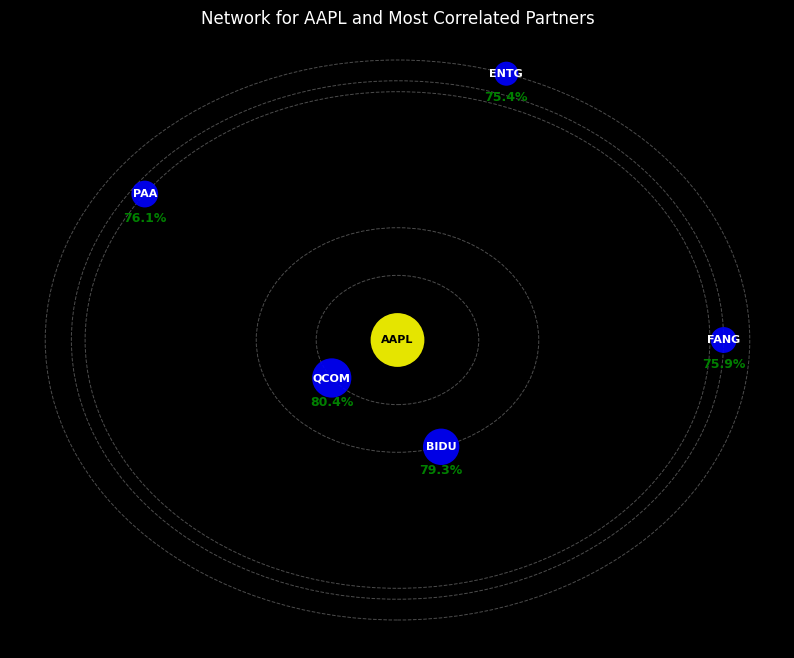

In [ ]:
# Example usage:


# OLD: Download Raw Stock Data to My Drive

# Import already manipulated parquet from MyDrive

In [ ]:
#function for importing parquet from MyDrive
def import_variable(file_name):
  load_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}"

  try:
      variable = pd.read_parquet(load_path)

      print(f"Successfully loaded data from {load_path}")

  except FileNotFoundError:
      print(f"Error: The file was not found at {load_path}")
  except Exception as e:
      print(f"An error occurred while loading the file: {e}")
  return variable

# #run this funciton with this line
# x = import_variable("testing2_2025-05-22 19:07:29.595379.parquet")

In [ ]:
# #import correlation data from entire stock data that I saved off earlier on MyDrive
#pearson_sixMonth_correlation_data = import_variable("6month_correlation_data.parquet")
spearman_sixMonth_correlation_data = import_variable("spearman_lagged_correlations_2025-06-03 18:13:09.551585.parquet")





Successfully loaded data from /content/drive/MyDrive/Colab Notebooks/spearman_lagged_correlations_2025-06-03 18:13:09.551585.parquet


In [ ]:
# Run this if I need to download historical data and save it to MyDrive
def DownloadStockData():
  #Download the stock data
  !if [ ! -f "usa_stocks_30m.parquet" ]; then curl https://storage.googleapis.com/rapidsai/colab-data/usa_stocks_30m.parquet -o usa_stocks_30m.parquet; else echo "usa_stocks_30m.parquet found"; fi

  #move the stock data to my Drive
  !mv usa_stocks_30m.parquet "/content/drive/MyDrive/Colab Notebooks"
# DownloadStockData()

# Run this if I have already downloaded the hisotrical data and need to import
# Historical data from MyDrive
def ImportStockData():
  # Import the stock data from My Drive
  # Define nasdaq_stocks as the stock data
  # Specify the full path to the file in your Google Drive
  nasdaq_stocks = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/usa_stocks_30m.parquet")
  return nasdaq_stocks
nasdaq_stocks = ImportStockData()


# Manipulate the historical data for correlation function
def ManipulateStockData(nasdaq_stocks):
  #add year, month, and day columns
  #df[["year", "week", "day"]] = df.datetime.dt.isocalendar()
  nasdaq_stocks["year"] = nasdaq_stocks.datetime.dt.year
  nasdaq_stocks["month"] = nasdaq_stocks.datetime.dt.month
  nasdaq_stocks["day"] = nasdaq_stocks.datetime.dt.day

  # #Filter the DataFrame based on the 'year' column
  # stock_TimeFiltered = nasdaq_stocks.loc[nasdaq_stocks['year'] >= 2023]

  #stock_TimeFiltered.info()
  #stock_TimeFiltered.head()

  #aggregate data by ticker, month, day, closing cost.
  stock_TimeFiltered_aggregated_close = nasdaq_stocks.groupby(["ticker", "year", "month", "day"]).agg({"close": "last"})

  #stock_TimeFiltered_aggregated_close.info()
  #stock_TimeFiltered_aggregated_close.head()
  return stock_TimeFiltered_aggregated_close

stock_TimeFiltered_aggregated_close = ManipulateStockData(nasdaq_stocks)

In [ ]:
nasdaq_stocks.head()

,datetime,open,high,low,close,volume,ticker
0,1999-11-18 17:00:00,45.56,50.00,45.50,46.00,9275000,A
1,1999-11-18 17:30:00,46.00,47.69,45.82,46.57,3200900,A
2,1999-11-18 18:00:00,46.56,46.63,41.00,41.00,3830500,A
3,1999-11-18 18:30:00,41.00,43.38,40.37,42.38,3688600,A
4,1999-11-18 19:00:00,42.31,42.44,41.56,41.69,1584300,A


In [ ]:
  # Convert end_date to datetime object
  end_date = '2023-12-31'
  range_months = 6

   # Convert end_date to datetime object
  end_datetime = pd.to_datetime(end_date)

  # Calculate the start date for the 6-month period
  start_datetime = end_datetime - pd.DateOffset(months = range_months)

    # Filter the DataFrame for the specified date range
  # We need to create a datetime column from the index to filter
  aapl_data['datetime'] = pd.to_datetime(aapl_data.index.get_level_values('year').astype(str) + '-' +
                                   aapl_data.index.get_level_values('month').astype(str) + '-' +
                                   aapl_data.index.get_level_values('day').astype(str))
  filtered_df = aapl_data[(aapl_data['datetime'] >= start_datetime) & (aapl_data['datetime'] <= end_datetime)]
  filtered_df = filtered_df.drop(columns=['datetime']) # Drop the temporary datetime column

# Function: Export variables to My Drive

In [ ]:
# Export a panda dataframe to MyDrive
def export_variable(variable_name, file_name):

  now = datetime.datetime.now()

  save_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}_{now}.parquet"

  try:
      variable_name.to_parquet(save_path)
      print(f"Successfully saved the variable to {save_path}")
  except Exception as e:
      print(f"An error occurred while saving the file: {e}")
  return

export_variable(spearman_lagged_correlations, "spearman_lagged_correlations")

Successfully saved the variable to /content/drive/MyDrive/Colab Notebooks/spearman_lagged_correlations_2025-06-03 18:13:09.551585.parquet
